In [1]:
import json
import numpy as np
import glob
import os

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import pandas as pd

import importlib

from dredFISH.Analysis.__init__plots import *
from dredFISH.Analysis import basicu 

from dredFISH.Design.model_v1p3_gene_celltype_tuneinit import CellTypeNet
from dredFISH.Design import data_loader_scrna 
importlib.reload(data_loader_scrna)

<module 'dredFISH.Design.data_loader_scrna' from '/bigstore/GeneralStorage/fangming/projects/dredfish/packages/dredFISH/dredFISH/Design/data_loader_scrna.py'>

In [2]:
def get_mse_torch(tnsr_true, tnsr_pred=[]):
    """Mean (over rows) squared error
    if no pred, returns the variance.
    """
    if len(tnsr_pred):
        mse = (tnsr_true - tnsr_pred).square().mean(axis=0)
    else:
        mse = (tnsr_true - tnsr_true.mean(axis=0)).square().mean(axis=0)
    return mse
        
def get_r2_torch(tnsr_true, tnsr_pred, zero_tol=1e-10):
    """
    """
    mse = get_mse_torch(tnsr_true, tnsr_pred)
    var = get_mse_torch(tnsr_true)
    r2 = 1-mse/torch.clamp(var, min=zero_tol)
    return r2

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [3]:
rootdat_dir = '/bigstore/GeneralStorage/fangming/projects/dredfish/res_nn/' 
!ls $rootdat_dir

00_test_recon
01_test_recon
02-2_reduced_class_longiter
02_reduced_class
03-1_gpu
03-2_cpu
04-1_gpu
04-2_cpu
05-1_drprt0.0
05-1_drprt0.1
05-1_drprt0.2
05-1_drprt0.3
05-1_drprt0.4
05-1_drprt0.5
05-1_drprt0.6
05-1_drprt0.7
05-1_drprt0.8
05-1_drprt0.9
06-gene140
06-gene140_lmd01.00e-01
06-gene140_lmd01.00e+01
06-gene140_lmd01.00e-03
06-gene140_lmd01.00e+03
06-gene140_lmd01.00e-05
06-gene140_lmd01.00e+05
06-v3-simple-gene140_1.00e+00
06-v3-simple-gene140_1.00e-05
06-v3-simple-gene140_1.00e+05
06-v4-gene140_lmd01.00e+00
06-v4-gene140_lmd01.00e-05
06-v4-gene140_lmd01.00e+05
06-v5-gene140_lmd01.00e+05
06-v6-simple-gene140_lmd01.00e+05_nbit100
06-v6-simple-gene140_lmd01.00e+05_nbit50
06-v6-simple-gene140_lmd01.00e+05_nbit70
06-v7-simple-gene140_lmd01.00e+05_nbit70_nrcn1
06-v7-simple-gene140_lmd01.00e+05_nbit70_nrcn1_lr0.001
06-v7-simple-gene140_lmd01.00e+05_nbit70_nrcn1_lr0.01
06-v7-simple-gene140_lmd01.00e+05_nbit70_nrcn1_lr0.1
06-v7-simple-gene140_lmd01.00e+05_nbit70_nrcn1_lr1
06-v7-simple-g

In [48]:
nbits = [3,6,12,24,48,72,96]
n_bits_acc = []

for nbit in nbits:
    print(nbit)
    # nbit = 12
    
    nrcn = 1
    lr = 0.1
    dat_dir = rootdat_dir + f'11-smrt-zdim_lmd01.00e+00_nbit{nbit}_nrcn{nrcn}_lr{lr}'
    print(os.path.isdir(dat_dir), dat_dir)

    # # results
    # f = glob.glob(os.path.join(dat_dir, 'result*'))[0]
    # with open(f, 'r') as fh:
    #     res = json.load(fh)

#     # get specifics
#     lc_x = []
#     lc_ttl = []

#     lc_rcn_lss = []
#     lc_ctg_lss = []
#     lc_fine_acc = []

#     lc_rcn_lss_eval = []
#     lc_ctg_lss_eval = []
#     lc_fine_acc_eval = []

#     for _epoch in res.keys():
#         _iters = list(res[_epoch].keys())
#         steps = np.arange(len(_iters))/len(_iters)
#         lc_x = np.hstack([lc_x, (int(_epoch) + steps)])

#         lc_ttl = np.hstack([lc_ttl, [res[_epoch][_iter]['ttl'] for _iter in _iters]])

#         lc_rcn_lss = np.hstack([lc_rcn_lss, [res[_epoch][_iter]['rcn_lss'] for _iter in _iters]])
#         lc_ctg_lss = np.hstack([lc_ctg_lss, [res[_epoch][_iter]['ctg_lss'] for _iter in _iters]])
#         lc_fine_acc = np.hstack([lc_fine_acc, [res[_epoch][_iter]['fine_acc'] for _iter in _iters]])

#         lc_rcn_lss_eval = np.hstack([lc_rcn_lss_eval, [res[_epoch][_iter]['rcn_lss_eval'] for _iter in _iters]])
#         lc_ctg_lss_eval = np.hstack([lc_ctg_lss_eval, [res[_epoch][_iter]['ctg_lss_eval'] for _iter in _iters]])
#         lc_fine_acc_eval = np.hstack([lc_fine_acc_eval, [res[_epoch][_iter]['fine_acc_eval'] for _iter in _iters]])

    # prep the model
    f = glob.glob(os.path.join(dat_dir, 'model*'))[0]

    reduction, cnst, mxpr, min_pos, n_bit, drprt, lmd1, lmd2, lmd3 = (os.path.basename(f)
                                                                            [len('model='):-len('.pt')]
                                                                            .replace('E-', 'expn').split('-')
                                                                     )
    lmd0 = 1
    mxpr = np.float64(mxpr)
    n_bit = int(n_bit)
    drprt = np.float64(drprt)
    # reduction, cnst, mxpr, min_pos, n_bit, drprt, lmd1, lmd2, lmd3

    trn_dataloader = data_loader_scrna.load_Allen_data(
        datasetkey='smrt_trn', 
        keyX='counts', keyY='l3_code', keyYcat='l3_cat', 
        batch_size=64,
    )
    tst_dataloader = data_loader_scrna.load_Allen_data(
        datasetkey='smrt_tst', 
        keyX='counts', keyY='l3_code', keyYcat='l3_cat', 
        batch_size=500,
    )
    gsubidx = torch.load(
        os.path.join('/bigstore/GeneralStorage/fangming/projects/dredfish/data/', 'rna', 'gidx_sub140_smrt_v1.pt')
    )

    n_gns = trn_dataloader.dataset.X.shape[1] # number of genes
    n_cat = len(trn_dataloader.dataset.Ycat) # number of clusters
    cnstrnts = torch.tensor(trn_dataloader.dataset.data['num_probe_limit'])
    n_rcn_layers = nrcn

    model= CellTypeNet(n_gns=     n_gns,                      
                       n_cat=     n_cat,                      
                       gsubidx= gsubidx,
                       n_rcn_layers=n_rcn_layers,
                       n_bit=     n_bit,                      # fixed
                       mxpr=      mxpr,
                       drprt=     0,
                       lmd0=      lmd0,
                      )
    model.load_state_dict(torch.load(f, map_location=device))

    # evaluate
    model.eval()
    i = 0
    with torch.no_grad():
        # validation dataset
        ftrs, clsts = next(iter(tst_dataloader))
        ftrs= ftrs.float().to(device)
        clsts= clsts.long().to(device)
        ftrs_gsub= (ftrs[:,gsubidx]+1).log() # log(x+1) norm

        plgt_fine, ftrs_rcn, emb = model.forward(ftrs, rnd=True)
        prds_fine = plgt_fine.max(1)[1]
        rcn_lss_eval = nn.MSELoss()(ftrs_rcn, ftrs_gsub)
        ctg_lss_eval = nn.CrossEntropyLoss()(plgt_fine, clsts)
        fine_acc_eval = (prds_fine == clsts).float().mean()
        r2_val = get_r2_torch(ftrs_gsub, ftrs_rcn)
        print(f"acc: {fine_acc_eval}")
        n_bits_acc.append(fine_acc_eval)
        
    # save results
    out_sum = os.path.join(dat_dir, "gene_recon_r2.csv")
    print(out_sum)
    pd.DataFrame(r2_val).to_csv(out_sum)
    
    # out_sum = os.path.join(dat_dir, "mean_classification_acc.csv")
    # print(out_sum)
    # pd.DataFrame(fine_acc_eval).to_csv(out_sum)

3
True /bigstore/GeneralStorage/fangming/projects/dredfish/res_nn/11-smrt-zdim_lmd01.00e+00_nbit3_nrcn1_lr0.1
acc: 0.734000027179718
/bigstore/GeneralStorage/fangming/projects/dredfish/res_nn/11-smrt-zdim_lmd01.00e+00_nbit3_nrcn1_lr0.1/gene_recon_r2.csv
6
True /bigstore/GeneralStorage/fangming/projects/dredfish/res_nn/11-smrt-zdim_lmd01.00e+00_nbit6_nrcn1_lr0.1
acc: 0.972000002861023
/bigstore/GeneralStorage/fangming/projects/dredfish/res_nn/11-smrt-zdim_lmd01.00e+00_nbit6_nrcn1_lr0.1/gene_recon_r2.csv
12
True /bigstore/GeneralStorage/fangming/projects/dredfish/res_nn/11-smrt-zdim_lmd01.00e+00_nbit12_nrcn1_lr0.1
acc: 0.972000002861023
/bigstore/GeneralStorage/fangming/projects/dredfish/res_nn/11-smrt-zdim_lmd01.00e+00_nbit12_nrcn1_lr0.1/gene_recon_r2.csv
24
True /bigstore/GeneralStorage/fangming/projects/dredfish/res_nn/11-smrt-zdim_lmd01.00e+00_nbit24_nrcn1_lr0.1
acc: 0.9639999866485596
/bigstore/GeneralStorage/fangming/projects/dredfish/res_nn/11-smrt-zdim_lmd01.00e+00_nbit24_nrcn1_l

In [15]:
nbits = [3,6,12,24,48,72,96]
res_r2 = pd.DataFrame()

for nbit in nbits:
    print(nbit)
    # nbit = 12
    
    nrcn = 1
    lr = 0.1
    dat_dir = rootdat_dir + f'11-smrt-zdim_lmd01.00e+00_nbit{nbit}_nrcn{nrcn}_lr{lr}'
    print(os.path.isdir(dat_dir), dat_dir)
    f = os.path.join(dat_dir, 'gene_recon_r2.csv')
    df = pd.read_csv(f)['0']
    res_r2[nbit] = df.values
    

3
True /bigstore/GeneralStorage/fangming/projects/dredfish/res_nn/11-smrt-zdim_lmd01.00e+00_nbit3_nrcn1_lr0.1
6
True /bigstore/GeneralStorage/fangming/projects/dredfish/res_nn/11-smrt-zdim_lmd01.00e+00_nbit6_nrcn1_lr0.1
12
True /bigstore/GeneralStorage/fangming/projects/dredfish/res_nn/11-smrt-zdim_lmd01.00e+00_nbit12_nrcn1_lr0.1
24
True /bigstore/GeneralStorage/fangming/projects/dredfish/res_nn/11-smrt-zdim_lmd01.00e+00_nbit24_nrcn1_lr0.1
48
True /bigstore/GeneralStorage/fangming/projects/dredfish/res_nn/11-smrt-zdim_lmd01.00e+00_nbit48_nrcn1_lr0.1
72
True /bigstore/GeneralStorage/fangming/projects/dredfish/res_nn/11-smrt-zdim_lmd01.00e+00_nbit72_nrcn1_lr0.1
96
True /bigstore/GeneralStorage/fangming/projects/dredfish/res_nn/11-smrt-zdim_lmd01.00e+00_nbit96_nrcn1_lr0.1


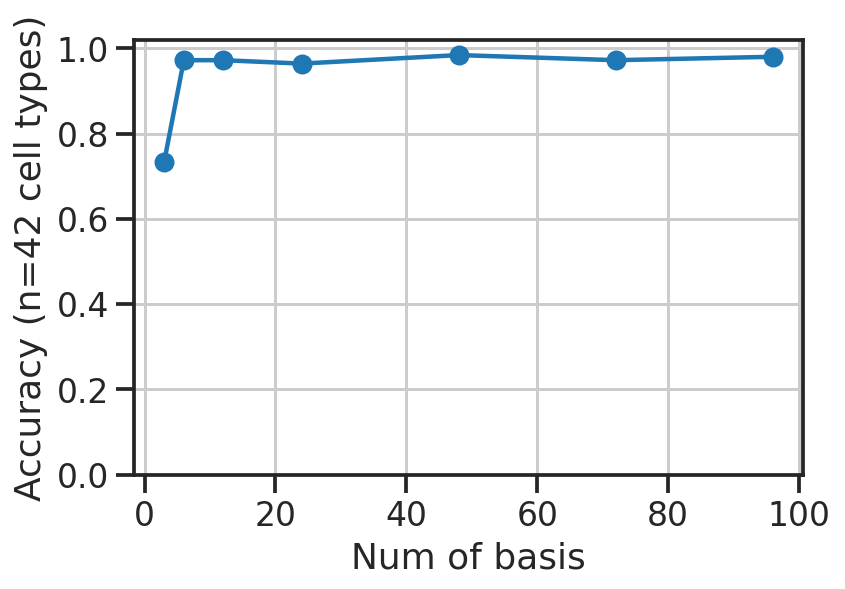

In [55]:
fig, ax = plt.subplots()
ax.plot(nbits, n_bits_acc, '-o')
ax.set_ylim([0,1.02])
ax.set_xlabel('Num of basis')
ax.set_ylabel('Accuracy (n=42 cell types)')
plt.show()

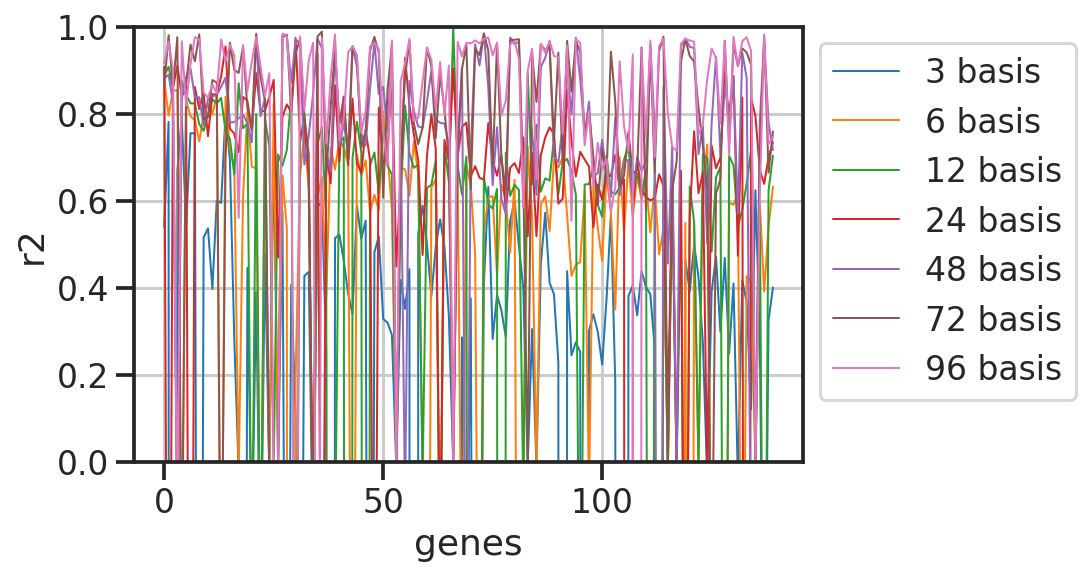

In [24]:
fig, ax = plt.subplots()
for col in res_r2:
    ax.plot(res_r2[col], linewidth=1, label=f"{col} basis")
ax.set_ylim([0,1])
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('genes')
ax.set_ylabel('r2')
plt.show()

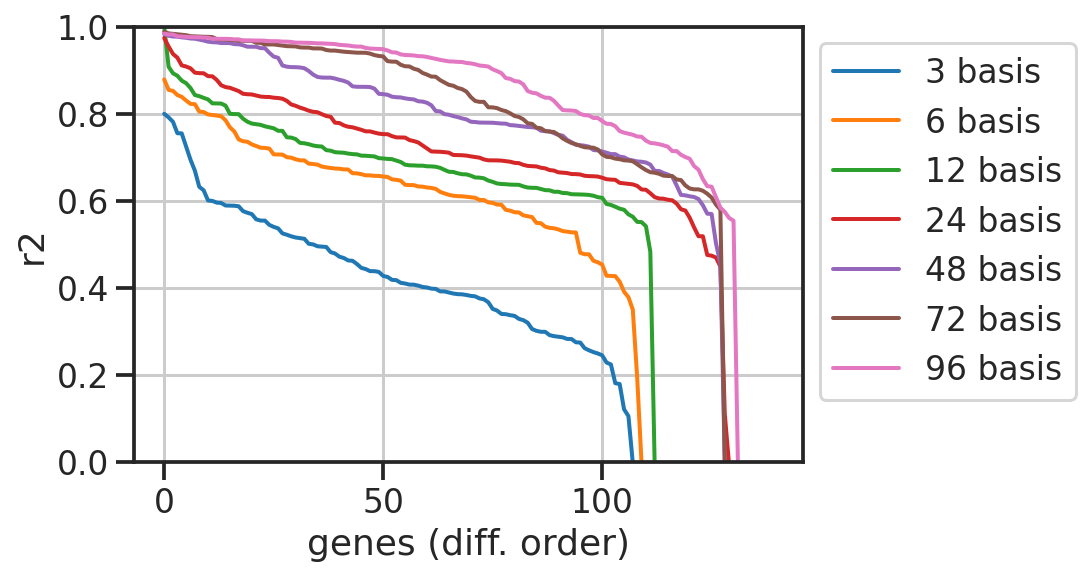

In [42]:
fig, ax = plt.subplots()
for col in res_r2:
    ax.plot(np.sort(res_r2[col])[::-1], linewidth=2, label=f"{col} basis")
ax.set_ylim([0,1])
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('genes (diff. order)')
ax.set_ylabel('r2')
plt.show()

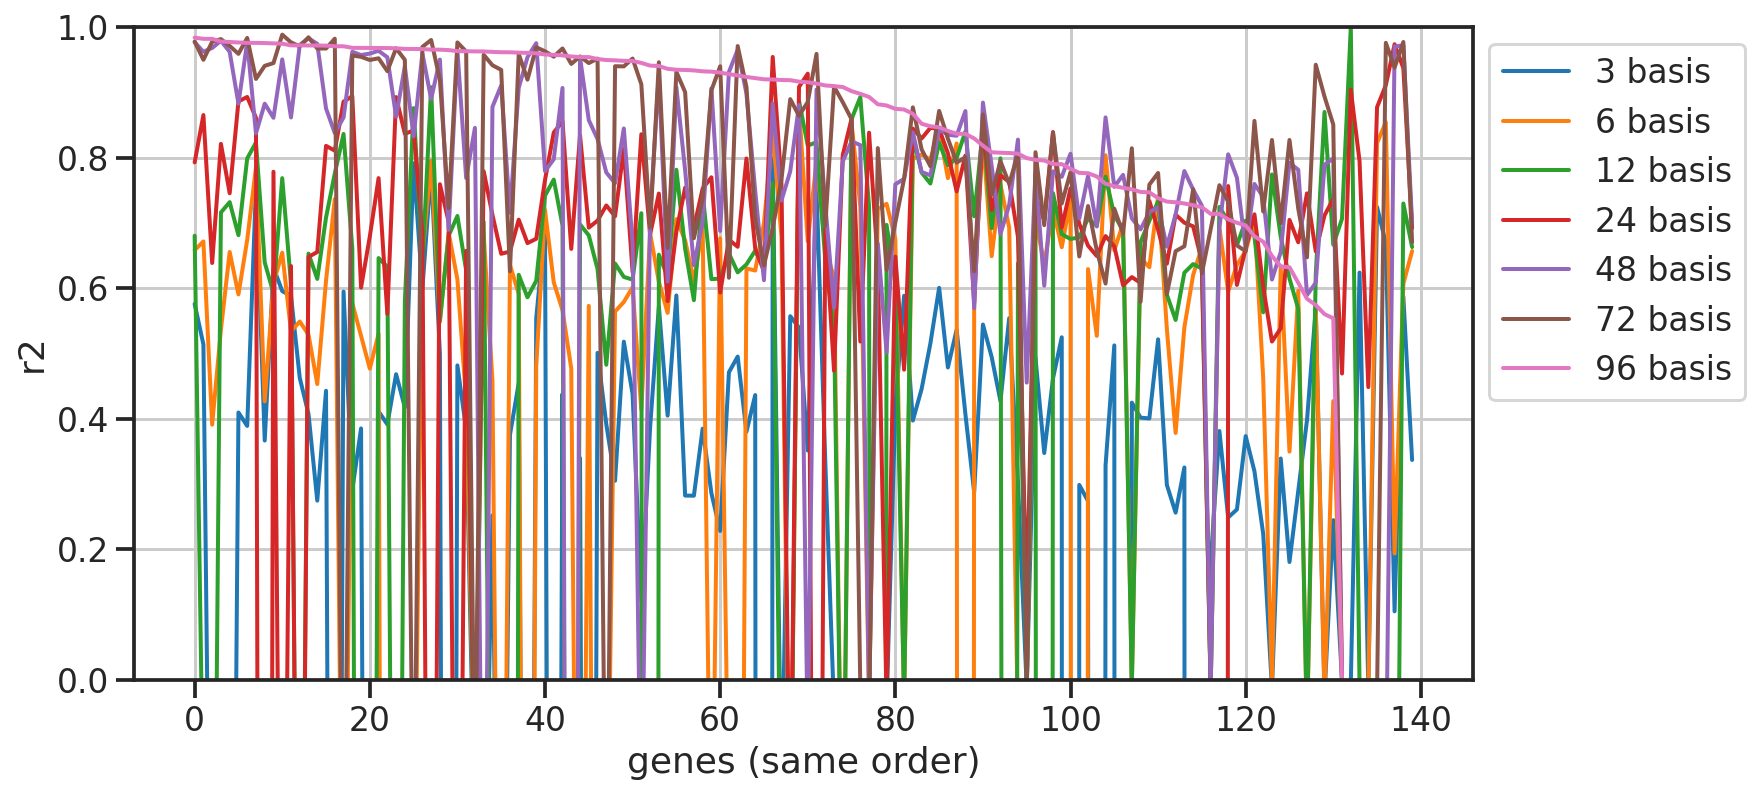

In [43]:
res_or2 = res_r2.sort_values(96, ascending=False)

fig, ax = plt.subplots(figsize=(12,6))
for col in res_or2:
    ax.plot(res_or2[col].values, linewidth=2, label=f"{col} basis")
ax.set_ylim([0,1])
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('genes (same order)')
ax.set_ylabel('r2')
plt.show()

In [5]:
!ls $dat_dir

'embmat=xxx-xxx-90000.0-xxx-96-0-xxx-xxx-xxx.json'
 gene_recon_r2.csv
'model=xxx-xxx-90000.0-xxx-96-0-xxx-xxx-xxx.pt'
'result=xxx-xxx-90000.0-xxx-96-0-xxx-xxx-xxx.json'
